### Uczenie maszynowe
# 2. Regresja liniowa – część 1

## 2.1. Funkcja kosztu

### Zadanie
Znając $x$ – ludność miasta, należy przewidzieć $y$ – dochód firmy transportowej.

(Dane pochodzą z kursu „Machine Learning”, Andrew Ng, Coursera).

**Uwaga**: Ponieważ ten przykład ma być tak prosty, jak to tylko możliwe, ludność miasta podana jest w dziesiątkach tysięcy mieszkańców, a dochód firmy w dziesiątkach tysięcy dolarów. Dzięki temu funkcja kosztu obliczona w dalszej części wykładu będzie osiągać wartości, które łatwo przedstawić na wykresie.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

%matplotlib inline
%config InlineBackend.figure_format = "svg"

from IPython.display import display, Math, Latex

### Dane

In [3]:
import pandas as pd

data = pd.read_csv("data1_train.csv", names=["x", "y"])
print(data)


          x         y
0    6.1101  17.59200
1    5.5277   9.13020
2    8.5186  13.66200
3    7.0032  11.85400
4    5.8598   6.82330
..      ...       ...
75   6.5479   0.29678
76   7.5386   3.88450
77   5.0365   5.70140
78  10.2740   6.75260
79   5.1077   2.05760

[80 rows x 2 columns]


In [4]:
x = data["x"].to_numpy()
y = data["y"].to_numpy()


### Hipoteza i parametry modelu

Jak przewidzieć $y$ na podstawie danego $x$? W celu odpowiedzi na to pytanie będziemy starać się znaleźć taką funkcję $h(x)$, która będzie najlepiej obrazować zależność między $x$ a $y$, tj. $y \sim h(x)$.

Zacznijmy od najprostszego przypadku, kiedy $h(x)$ jest po prostu funkcją liniową. Ogólny wzór funkcji liniowej to

$$ h(x) = a \, x + b $$

Pamiętajmy jednak, że współczynniki $a$ i $b$ nie są w tej chwili dane z góry – naszym zadaniem właśnie będzie znalezienie takich ich wartości, żeby $h(x)$ było „możliwie jak najbliżej” $y$ (co właściwie oznacza to sformułowanie, wyjaśnię potem).

Poszukiwaną funkcję $h$ będziemy nazywać **funkcją hipotezy**, a jej współczynniki – **parametrami modelu**.

W teorii uczenia maszynowego parametry modelu oznacza się na ogół grecką literą $\theta$ z odpowiednimi indeksami, dlatego powyższy wzór opisujący liniową funkcję hipotezy zapiszemy jako
$$ h(x) = \theta_0 + \theta_1 x $$

**Parametry modelu** tworzą wektor, który oznaczymy po prostu przez $\theta$:

$$ \theta = \left[\begin{array}{c}\theta_0\\ \theta_1\end{array}\right] $$

Żeby podkreślić fakt, że funkcja hipotezy zależy od parametrów modelu, będziemy pisać $h_\theta$ zamiast $h$:

$$ h_{\theta}(x) = \theta_0 + \theta_1 x $$

Przyjrzyjmy się teraz, jak wyglądają dane, które mamy modelować:

Na poniższym wykresie możesz spróbować ręcznie dopasować parametry modelu $\theta_0$ i $\theta_1$ tak, aby jak najlepiej modelowały zależność między $x$ a $y$:

In [5]:
# Funkcje rysujące wykres kropkowy oraz prostą regresyjną


def regdots(x, y):
    fig = plt.figure(figsize=(16 * 0.6, 9 * 0.6))
    ax = fig.add_subplot(111)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    ax.scatter(x, y, c="r", label="Dane")

    ax.set_xlabel("Wielkość miejscowości")
    ax.set_ylabel("Dochód firmy")
    ax.margins(0.05, 0.05)
    plt.ylim(min(y) - 1, max(y) + 1)
    plt.xlim(min(x) - 1, max(x) + 1)
    return fig


def regline(fig, fun, theta, x):
    ax = fig.axes[0]
    x0, x1 = min(x), max(x)
    X = [x0, x1]
    Y = [fun(theta, x) for x in X]
    ax.plot(
        X,
        Y,
        linewidth="2",
        label=(
            r"$y={theta0}{op}{theta1}x$".format(
                theta0=theta[0],
                theta1=(theta[1] if theta[1] >= 0 else -theta[1]),
                op="+" if theta[1] >= 0 else "-",
            )
        ),
    )


def legend(fig):
    ax = fig.axes[0]
    handles, labels = ax.get_legend_handles_labels()
    # try-except block is a fix for a bug in Poly3DCollection
    try:
        fig.legend(handles, labels, fontsize="15", loc="lower right")
    except AttributeError:
        pass


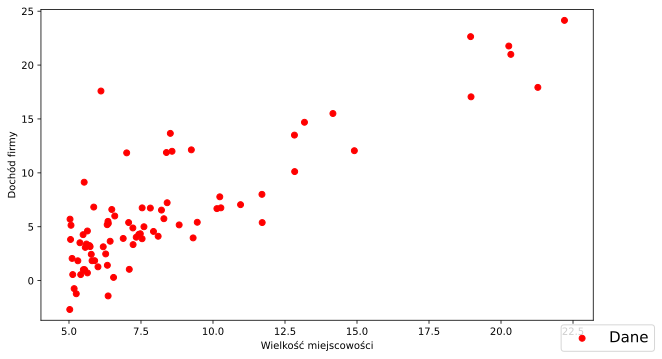

In [6]:
fig = regdots(x, y)
legend(fig)


In [7]:
# Hipoteza: funkcja liniowa jednej zmiennej


def h(theta, x):
    return theta[0] + theta[1] * x


In [8]:
# Przygotowanie interaktywnego wykresu

sliderTheta01 = widgets.FloatSlider(
    min=-10, max=10, step=0.1, value=0, description=r"$\theta_0$", width=300
)
sliderTheta11 = widgets.FloatSlider(
    min=-5, max=5, step=0.1, value=0, description=r"$\theta_1$", width=300
)


def slide1(theta0, theta1):
    fig = regdots(x, y)
    regline(fig, h, [theta0, theta1], x)
    legend(fig)


In [30]:
widgets.interact_manual(slide1, theta0=sliderTheta01, theta1=sliderTheta11)

interactive(children=(FloatSlider(value=0.0, description='$\\theta_0$', max=10.0, min=-10.0), FloatSlider(valu…

<function __main__.slide1(theta0, theta1)>

Skąd wiadomo, że przewidywania modelu (wartości funkcji $h(x)$) zgadzaja się z obserwacjami (wartości $y$)?

Aby to zmierzyć wprowadzimy pojęcie funkcji kosztu.

### Funkcja kosztu

Funkcję kosztu zdefiniujemy w taki sposób, żeby odzwierciedlała ona różnicę między przewidywaniami modelu a obserwacjami.

Jedną z możliwosci jest zdefiniowanie funkcji kosztu jako wartość **błędu średniokwadratowego** (metoda najmniejszych kwadratów, *mean-square error, MSE*).

My zdefiniujemy funkcję kosztu jako *połowę* błędu średniokwadratowego w celu ułatwienia późniejszych obliczeń (obliczenie pochodnej funkcji kosztu w dalszej części wykładu). Możemy tak zrobić, ponieważ $\frac{1}{2}$ jest stałą, a pomnożenie przez stałą nie wpływa na przebieg zmienności funkcji.

$$ J(\theta) \, = \, \frac{1}{2m} \sum_{i = 1}^{m} \left( h_{\theta} \left( x^{(i)} \right) - y^{(i)} \right) ^2 $$

gdzie $m$ jest liczbą wszystkich przykładów (obserwacji), czyli wielkością zbioru danych uczących.

W powyższym wzorze sumujemy kwadraty różnic między przewidywaniami modelu ($h_\theta \left( x^{(i)} \right)$) a obserwacjami ($y^{(i)}$) po wszystkich przykładach $i$.

Teraz nasze zadanie sprowadza się do tego, że będziemy szukać takich parametrów $\theta = \left[\begin{array}{c}\theta_0\\ \theta_1\end{array}\right]$, które minimalizują fukcję kosztu $J(\theta)$:

$$ \hat\theta = \mathop{\arg\min}_{\theta} J(\theta) $$

$$ \theta \in \mathbb{R}^2, \quad J \colon \mathbb{R}^2 \to \mathbb{R} $$

Proszę zwrócić uwagę, że dziedziną funkcji kosztu jest zbiór wszystkich możliwych wartości parametrów $\theta$.

$$ J(\theta_0, \theta_1) \, = \, \frac{1}{2m} \sum_{i = 1}^{m} \left( \theta_0 + \theta_1 x^{(i)} - y^{(i)} \right) ^2 $$

In [10]:
def J(h, theta, x, y):
    """Funkcja kosztu"""
    m = len(y)
    return 1.0 / (2 * m) * sum((h(theta, x[i]) - y[i]) ** 2 for i in range(m))


In [11]:
# Oblicz wartość funkcji kosztu i pokaż na wykresie


def regline2(fig, fun, theta, xx, yy):
    """Rysuj regresję liniową"""
    ax = fig.axes[0]
    x0, x1 = min(xx), max(xx)
    X = [x0, x1]
    Y = [fun(theta, x) for x in X]
    cost = J(fun, theta, xx, yy)
    ax.plot(
        X,
        Y,
        linewidth="2",
        label=(
            r"$y={theta0}{op}{theta1}x, \; J(\theta)={cost:.3}$".format(
                theta0=theta[0],
                theta1=(theta[1] if theta[1] >= 0 else -theta[1]),
                op="+" if theta[1] >= 0 else "-",
                cost=cost,
            )
        ),
    )


sliderTheta02 = widgets.FloatSlider(
    min=-10, max=10, step=0.1, value=0, description=r"$\theta_0$", width=300
)
sliderTheta12 = widgets.FloatSlider(
    min=-5, max=5, step=0.1, value=0, description=r"$\theta_1$", width=300
)


def slide2(theta0, theta1):
    fig = regdots(x, y)
    regline2(fig, h, [theta0, theta1], x, y)
    legend(fig)


Poniższy interaktywny wykres pokazuje wartość funkcji kosztu $J(\theta)$. Czy teraz łatwiej jest dobrać parametry modelu?

In [12]:
widgets.interact_manual(slide2, theta0=sliderTheta02, theta1=sliderTheta12)


interactive(children=(FloatSlider(value=0.0, description='$\\theta_0$', max=10.0, min=-10.0), FloatSlider(valu…

<function __main__.slide2(theta0, theta1)>

### Funkcja kosztu jako funkcja zmiennej $\theta$

Funkcja kosztu zdefiniowana jako MSE jest funkcją zmiennej wektorowej $\theta$, czyli funkcją dwóch zmiennych rzeczywistych: $\theta_0$ i $\theta_1$.
    
Zobaczmy, jak wygląda jej wykres.

In [13]:
# Wykres funkcji kosztu dla ustalonego theta_1=1.0


def costfun(fun, x, y):
    return lambda theta: J(fun, theta, x, y)


def costplot(hypothesis, x, y, theta1=1.0):
    fig = plt.figure(figsize=(16 * 0.6, 9 * 0.6))
    ax = fig.add_subplot(111)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    ax.set_xlabel(r"$\theta_0$")
    ax.set_ylabel(r"$J(\theta)$")
    j = costfun(hypothesis, x, y)
    fun = lambda theta0: j([theta0, theta1])
    X = np.arange(-10, 10, 0.1)
    Y = [fun(x) for x in X]
    ax.plot(
        X, Y, linewidth="2", label=(r"$J(\theta_0, {theta1})$".format(theta1=theta1))
    )
    return fig


def slide3(theta1):
    fig = costplot(h, x, y, theta1)
    legend(fig)


sliderTheta13 = widgets.FloatSlider(
    min=-5, max=5, step=0.1, value=1.0, description=r"$\theta_1$", width=300
)


In [14]:
widgets.interact_manual(slide3, theta1=sliderTheta13)


interactive(children=(FloatSlider(value=1.0, description='$\\theta_1$', max=5.0, min=-5.0), Button(description…

<function __main__.slide3(theta1)>

In [15]:
# Wykres funkcji kosztu względem theta_0 i theta_1

from mpl_toolkits.mplot3d import Axes3D
import pylab

%matplotlib inline

def costplot3d(hypothesis, x, y, show_gradient=False):
    fig = plt.figure(figsize=(16*.6, 9*.6))
    ax = fig.add_subplot(111, projection='3d')
    fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
    ax.set_xlabel(r'$\theta_0$')
    ax.set_ylabel(r'$\theta_1$')
    ax.set_zlabel(r'$J(\theta)$')
    
    j = lambda theta0, theta1: costfun(hypothesis, x, y)([theta0, theta1])
    X = np.arange(-10, 10.1, 0.1)
    Y = np.arange(-1, 4.1, 0.1)
    X, Y = np.meshgrid(X, Y)
    Z = np.array([[J(hypothesis, [theta0, theta1], x, y) 
                    for theta0, theta1 in zip(xRow, yRow)] 
                   for xRow, yRow in zip(X, Y)])
    
    ax.plot_surface(X, Y, Z, rstride=2, cstride=8, linewidth=0.5,
                    alpha=0.5, cmap='jet', zorder=0,
                    label=r"$J(\theta)$")
    ax.view_init(elev=20., azim=-150)

    ax.set_xlim3d(-10, 10);
    ax.set_ylim3d(-1, 4);
    ax.set_zlim3d(-100, 800);

    N = range(0, 800, 20)
    plt.contour(X, Y, Z, N, zdir='z', offset=-100, cmap='coolwarm', alpha=1)
    
    ax.plot([-3.89578088] * 2,
            [ 1.19303364] * 2,
            [-100, 4.47697137598], 
            color='red', alpha=1, linewidth=1.3, zorder=100, linestyle='dashed',
            label=r'minimum: $J(-3.90, 1.19) = 4.48$')
    ax.scatter([-3.89578088] * 2,
               [ 1.19303364] * 2,
               [-100, 4.47697137598], 
               c='r', s=80, marker='x', alpha=1, linewidth=1.3, zorder=100, 
               label=r'minimum: $J(-3.90, 1.19) = 4.48$')
    
    if show_gradient:
        ax.plot([3.0, 1.1],
                [3.0, 2.4],
                [263.0, 125.0], 
                color='green', alpha=1, linewidth=1.3, zorder=100)
        ax.scatter([3.0],
                   [3.0],
                   [263.0], 
                   c='g', s=30, marker='D', alpha=1, linewidth=1.3, zorder=100)

    ax.margins(0,0,0)
    fig.tight_layout()

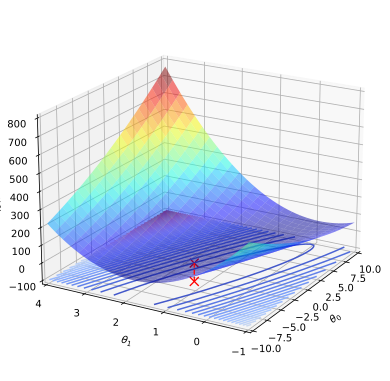

In [16]:
costplot3d(h, x, y)


Na powyższym wykresie poszukiwane minimum funkcji kosztu oznaczone jest czerwonym krzyżykiem.

Możemy też zobaczyć rzut powyższego trójwymiarowego wykresu na płaszczyznę $(\theta_0, \theta_1)$ poniżej:

In [17]:
def costplot2d(hypothesis, x, y, gradient_values=[], nohead=False):
    fig = plt.figure(figsize=(16 * 0.6, 9 * 0.6))
    ax = fig.add_subplot(111)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    ax.set_xlabel(r"$\theta_0$")
    ax.set_ylabel(r"$\theta_1$")

    j = lambda theta0, theta1: costfun(hypothesis, x, y)([theta0, theta1])
    X = np.arange(-10, 10.1, 0.1)
    Y = np.arange(-1, 4.1, 0.1)
    X, Y = np.meshgrid(X, Y)
    Z = np.array(
        [
            [
                J(hypothesis, [theta0, theta1], x, y)
                for theta0, theta1 in zip(xRow, yRow)
            ]
            for xRow, yRow in zip(X, Y)
        ]
    )

    N = range(0, 800, 20)
    plt.contour(X, Y, Z, N, cmap="coolwarm", alpha=1)

    ax.scatter(
        [-3.89578088],
        [1.19303364],
        c="r",
        s=80,
        marker="x",
        label=r"minimum: $J(-3.90, 1.19) = 4.48$",
    )

    if len(gradient_values) > 0:
        prev_theta = gradient_values[0][1]
        ax.scatter(
            [prev_theta[0]], [prev_theta[1]], c="g", s=30, marker="D", zorder=100
        )
        for cost, theta in gradient_values[1:]:
            dtheta = [theta[0] - prev_theta[0], theta[1] - prev_theta[1]]
            ax.arrow(
                prev_theta[0],
                prev_theta[1],
                dtheta[0],
                dtheta[1],
                color="green",
                head_width=(0.0 if nohead else 0.1),
                head_length=(0.0 if nohead else 0.2),
                zorder=100,
            )
            prev_theta = theta

    return fig


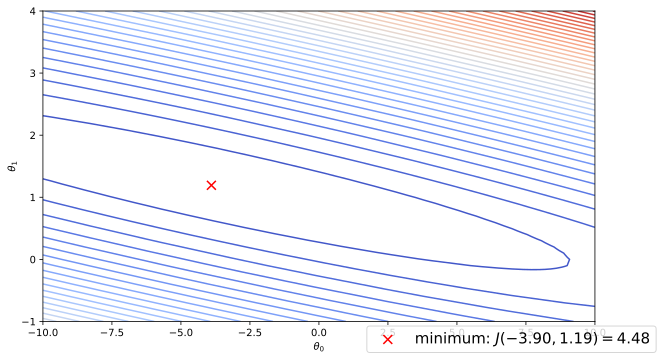

In [18]:
fig = costplot2d(h, x, y)
legend(fig)


### Cechy funkcji kosztu
Funkcja kosztu $J(\theta)$ zdefiniowana powyżej jest funkcją wypukłą, dlatego posiada tylko jedno minimum lokalne.

## 2.2. Metoda gradientu prostego

### Metoda gradientu prostego
Metoda znajdowania minimów lokalnych.

Idea:
 * Zacznijmy od dowolnego $\theta$.
 * Zmieniajmy powoli $\theta$ tak, aby zmniejszać $J(\theta)$, aż w końcu znajdziemy minimum.

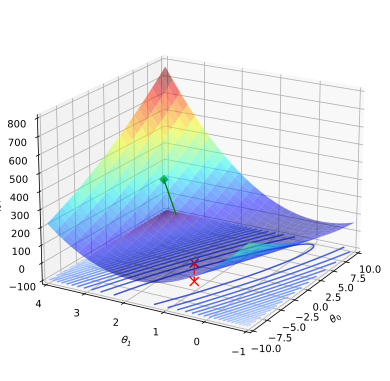

In [19]:
costplot3d(h, x, y, show_gradient=True)


In [20]:
# Przykładowe wartości kolejnych przybliżeń (sztuczne)

gv = [
    [_, [3.0, 3.0]],
    [_, [2.6, 2.4]],
    [_, [2.2, 2.0]],
    [_, [1.6, 1.6]],
    [_, [0.4, 1.2]],
]

# Przygotowanie interaktywnego wykresu

sliderSteps1 = widgets.IntSlider(
    min=0, max=3, step=1, value=0, description="kroki", width=300
)


def slide4(steps):
    costplot2d(h, x, y, gradient_values=gv[: steps + 1])


In [21]:
widgets.interact(slide4, steps=sliderSteps1)


interactive(children=(IntSlider(value=0, description='kroki', max=3), Output()), _dom_classes=('widget-interac…

<function __main__.slide4(steps)>

### Metoda gradientu prostego
W każdym kroku będziemy aktualizować parametry $\theta_j$:

$$ \theta_j := \theta_j - \alpha \frac{\partial}{\partial \theta_j} J(\theta) $$

Współczynnik $\alpha$ nazywamy **długością kroku** lub **współczynnikiem szybkości uczenia** (*learning rate*).

$$ \begin{array}{rcl}
\dfrac{\partial}{\partial \theta_j} J(\theta)
 & = & \dfrac{\partial}{\partial \theta_j} \dfrac{1}{2m} \displaystyle\sum_{i = 1}^{m} \left( h_{\theta} \left( x^{(i)} \right) - y^{(i)} \right) ^2 \\
 & = & 2 \cdot \dfrac{1}{2m} \displaystyle\sum_{i=1}^m \left( \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) \cdot \dfrac{\partial}{\partial\theta_j} \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) \right) \\
 & = & \dfrac{1}{m}\displaystyle\sum_{i=1}^m \left( \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) \cdot \dfrac{\partial}{\partial\theta_j} \left( \displaystyle\sum_{k=0}^n \theta_k x_k^{(i)} - y^{(i)} \right) \right) \\
 & = & \dfrac{1}{m}\displaystyle\sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) -y^{(i)} \right) x_j^{(i)} \\
\end{array} $$

Czyli dla regresji liniowej jednej zmiennej:

$$ h_\theta(x) = \theta_0 + \theta_1x $$

w każdym kroku będziemy aktualizować:

$$
\begin{array}{rcl}
\theta_0 & := & \theta_0 - \alpha \, \dfrac{1}{m}\displaystyle\sum_{i=1}^m \left( h_\theta(x^{(i)})-y^{(i)} \right) \\ 
\theta_1 & := & \theta_1 - \alpha \, \dfrac{1}{m}\displaystyle\sum_{i=1}^m \left( h_\theta(x^{(i)})-y^{(i)} \right) x^{(i)}\\ 
\end{array}
$$

###### Uwaga!
 * W każdym kroku aktualizujemy *jednocześnie* $\theta_0$ i $\theta_1$

 * Kolejne kroki wykonujemy aż uzyskamy zbieżność

### Metoda gradientu prostego – implementacja

In [22]:
# Wyświetlanie macierzy w LaTeX-u


def LatexMatrix(matrix):
    ltx = r"\left[\begin{array}"
    m, n = matrix.shape
    ltx += "{" + ("r" * n) + "}"
    for i in range(m):
        ltx += r" & ".join([("%.4f" % j.item()) for j in matrix[i]]) + r" \\ "
    ltx += r"\end{array}\right]"
    return ltx


In [23]:
def gradient_descent(h, cost_fun, theta, x, y, alpha, eps):
    current_cost = cost_fun(h, theta, x, y)
    history = [
        [current_cost, theta]
    ]  # zapiszmy wartości kosztu i parametrów, by potem zrobić wykres
    m = len(y)
    while True:
        new_theta = [
            theta[0] - alpha / float(m) * sum(h(theta, x[i]) - y[i] for i in range(m)),
            theta[1]
            - alpha / float(m) * sum((h(theta, x[i]) - y[i]) * x[i] for i in range(m)),
        ]
        theta = new_theta  # jednoczesna aktualizacja - używamy zmiennej tymczasowej
        try:
            prev_cost = current_cost
            current_cost = cost_fun(h, theta, x, y)
        except OverflowError:
            break
        if abs(prev_cost - current_cost) <= eps:
            break
        history.append([current_cost, theta])
    return theta, history


In [40]:
best_theta, history = gradient_descent(h, J, [0.0, 0.0], x, y, alpha=0.01, eps=0.0001)

display(
    Math(
        r"\large\textrm{Wynik:}\quad \theta = "
        + LatexMatrix(np.matrix(best_theta).reshape(2, 1))
        + (r" \quad J(\theta) = %.4f" % history[-1][0])
        + r" \quad \textrm{po %d iteracjach}" % len(history)
    )
)


<IPython.core.display.Math object>

In [25]:
# Przygotowanie interaktywnego wykresu

sliderSteps2 = widgets.IntSlider(
    min=0, max=500, step=1, value=1, description="kroki", width=300
)


def slide5(steps):
    costplot2d(h, x, y, gradient_values=history[: steps + 1], nohead=True)


In [ ]:
widgets.interact_manual(slide5, steps=sliderSteps2)


### Współczynnik szybkości uczenia $\alpha$ (długość kroku)

Tempo zbieżności metody gradientu prostego możemy regulować za pomocą parametru $\alpha$, pamiętając, że:

 * Jeżeli długość kroku jest zbyt mała, algorytm może działać zbyt wolno.

 * Jeżeli długość kroku jest zbyt duża, algorytm może nie być zbieżny.

## 2.3. Predykcja wyników

Zbudowaliśmy model, dzięki któremu wiemy, jaka jest zależność między dochodem firmy transportowej ($y$) a ludnością miasta ($x$).

Wróćmy teraz do postawionego na początku wykładu pytania: jak przewidzieć dochód firmy transportowej w mieście o danej wielkości?

Odpowiedź polega po prostu na zastosowaniu funkcji $h$ z wyznaczonymi w poprzednim kroku parametrami $\theta$.

Na przykład, jeżeli miasto ma $536\,000$ ludności, to $x = 53.6$ (bo dane uczące były wyrażone w dziesiątkach tysięcy mieszkańców, a $536\,000 = 53.6 \cdot 10\,000$) i możemy użyć znalezionych parametrów $\theta$, by wykonać następujące obliczenia:
$$ \hat{y} \, = \, h_\theta(x) \, = \, \theta_0 + \theta_1 \, x \, = \, 0.0494 + 0.7591 \cdot 53.6 \, = \, 40.7359 $$

Czyli używając zdefiniowanych wcześniej funkcji:

In [27]:
example_x = 53.6
predicted_y = h(best_theta, example_x)
print(
    predicted_y
)  ## taki jest przewidywany dochód tej firmy transportowej w 536-tysięcznym mieście


57.711124440555636


## 2.4. Ewaluacja modelu

Jak ocenić jakość stworzonego przez nas modelu?

 * Trzeba sprawdzić, jak przewidywania modelu zgadzają się z oczekiwaniami!

Czy możemy w tym celu użyć danych, których użyliśmy do uczenia modelu?

**NIE!**

 * Istotą uczenia maszynowego jest budowanie modeli/algorytmów, które dają dobre przewidywania dla **nieznanych** danych – takich, z którymi algorytm nie miał jeszcze styczności! Nie sztuką jest przewidywać rzeczy, które już sie zna.

 * Dlatego testowanie/ewaluowanie modelu **na zbiorze uczącym** mija się z celem i jest nieprzydatne.

 * Do ewaluacji modelu należy użyć oddzielnego zbioru danych.

 **Dane uczące i dane testowe zawsze powinny stanowić oddzielne zbiory!**

Na wykładzie *5. Dobre praktyki w uczeniu maszynowym* dowiesz się, jak podzielić posiadane dane na zbiór uczący i zbiór testowy.

Tutaj, na razie, do ewaluacji użyjemy specjalnie przygotowanego zbioru testowego.

Jako metrykę ewaluacji wykorzystamy znany nam już błąd średniokwadratowy (MSE):

In [28]:
def mse(expected, predicted):
    """Błąd średniokwadratowy"""
    m = len(expected)
    if len(predicted) != m:
        raise Exception("Wektory mają różne długości!")
    return 1.0 / (2 * m) * sum((expected[i] - predicted[i]) ** 2 for i in range(m))


In [41]:
# Wczytwanie danych testowych z pliku za pomocą numpy

test_data = np.loadtxt("data1_test.csv", delimiter=",")
x_test = test_data[:, 0]
y_test = test_data[:, 1]

# Obliczenie przewidywań modelu
y_pred = h(best_theta, x_test)

# Obliczenie MSE na zbiorze testowym (im mniejszy MSE, tym lepiej!)
evaluation_result = mse(y_test, y_pred)

print(evaluation_result)


3.713536032914909


Otrzymana wartość mówi nam o tym, jak dobry jest stworzony przez nas model.

W przypadku metryki MSE im mniejsza wartość, tym lepiej.

W ten sposób możemy np. porównywać różne modele.